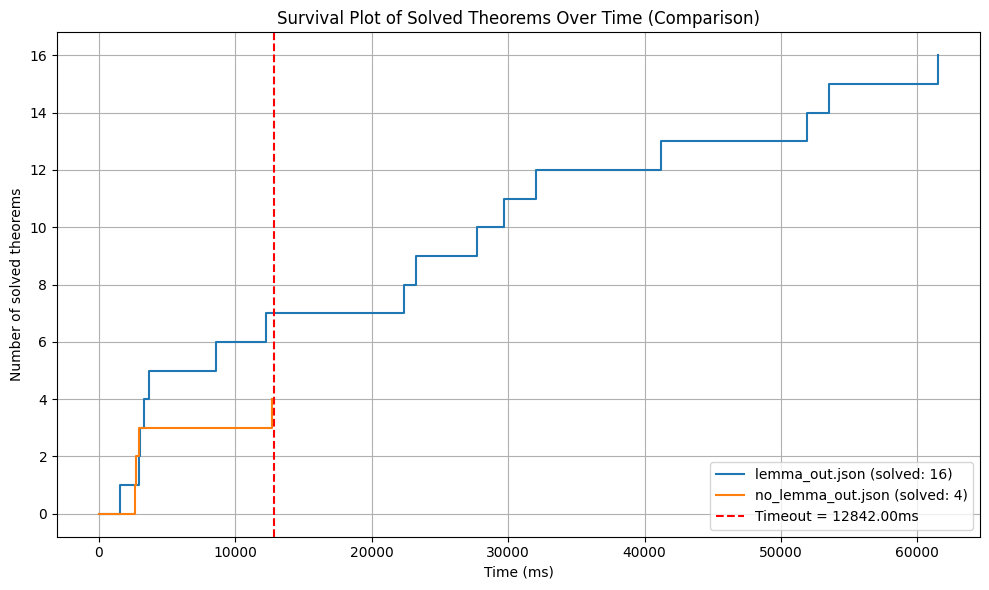

In [6]:
import json
import matplotlib.pyplot as plt

def extract_times(filename):
    with open(filename, 'r') as f:
        data = json.load(f)

    cvc4_times = [entry['total_time'] for entry in data.values() if entry['method'] == 'cvc4']
    timeout_times = [entry['total_time'] for entry in data.values() if entry['method'] == 'timeout']
    return sorted(cvc4_times), max(timeout_times) if timeout_times else max(cvc4_times)

def prepare_step_data(times):
    x = [0]
    y = [0]
    for i, t in enumerate(times, start=1):
        x.extend([t, t])
        y.extend([y[-1], i])
    return x, y

# Files to compare
file1 = 'lemma_out.json'
file2 = 'no_lemma_out.json'

# Extract data from both files
times1, timeout1 = extract_times(file1)
times2, timeout2 = extract_times(file2)

x1, y1 = prepare_step_data(times1)
x2, y2 = prepare_step_data(times2)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x1, y1, drawstyle='steps-post', label=f'{file1} (solved: {len(times1)})')
plt.plot(x2, y2, drawstyle='steps-post', label=f'{file2} (solved: {len(times2)})')

# Show the larger of the two timeout values
overall_timeout = max(timeout1, timeout2)
plt.axvline(overall_timeout, color='red', linestyle='--', label=f'Timeout = {overall_timeout:.2f}ms')

plt.xlabel('Time (ms)')
plt.ylabel('Number of solved theorems')
plt.title('Survival Plot of Solved Theorems Over Time (Comparison)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
